## **Datascience introduction - Capstone Project - Final**

### **Structure of this notebook**

This jupyter notebook is structured as follows:
- The environment is prepared. Packages are installed and libraries are imported.
- 6 Datasets are used. The retrieval and preparation of each dataset is described.
- Next the process of joining the datasets and further preparation of the data is explained. The aim is to get to one dataset to do the analysis on and subsequently the segmentation and clustering.
- Finally the clusters will be visualized on a map

### **Prepare the environment**

#### **Install packages**

Intall the webpage scraping package 'Beautiful Soup' and the html5 parser package. The geopy package is for handling geographical coordinates.

In [1]:
!conda install -c conda-forge beautifulsoup4 --yes
!conda install -c conda-forge html5lib --yes
!conda install -c conda-forge xlrd --yes
!conda install -c conda-forge geopy --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    soupsieve-1.9.3            |           py36_0          57 KB  conda-forge
    beautifulsoup4-4.8.0       |           py36_0         144 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         201 KB

The following NEW packages will be INSTALLED:

    soupsieve:      1.9.3-py36_0 conda-forge

The following packages will be UPDATED:

    beautifulsoup4: 4.6.3-py37_0             --> 4.8.0-py36_0 conda-forge


soupsieve-1.9.3     

#### **Import libraries**

Apart from the usual libraries like pandas and numpy, the following libraries are needed and should thus be imported: 
- webpage sraping (BeautifulSoup)
- getting and posting html requests
- data visualization (seaborn)
- matplotlib for 2D and 3D plotting
- folium for rendering maps

In [2]:
from bs4 import BeautifulSoup
import requests
#import csv
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
import folium

### **Datasets - obtain and prepare the data**

For this research 6 datasets are needed:
1. List of Toronto neighbourhoods and boroughs. The neighbourhoods are identified by their postal codes.
2. List of Geo spatial codes of the Toronto neighbourhoods
3. List of registered cats and dogs in Toronto from 2019 (Toronto open data)
4. List of neighbourhood profiles in Toronto from 2016 (Toronto open data)
5. List of postal codes and neighboorhoodnames from the neighbourhood profiles dataset
6. List of dogsitting and dogboarding venues in Toronto

#### **Dataset 1 - List of Toronto neighbourhoods and boroughs.**

Scrape a wikipage with the relevant data. Store the retrieved data in lists.
The scraping process is coded as follows:
- The url of the wikipage is passed as an argument to an html get request. The request is submitted and the resulting response is stored in the variable 'source'. 
- The source variable is passed along with an html parser to the BeautifulSoup constructor. The output is a tree containing all the parsed html tags. 
- With the soup's find methods the tree can be traversed using for loops. The tags that we are looking for are the table tag or the tablebody tag with the postcode data. We are specifically looking for the table rows (tag tr) and within the rows the header fields (tag th) and detail fields (tag td). 
- The text of the postal codes and the non assigned borough and neighbourhood names can be directly retrieved. The text values of assigned borough and neighbourhood names are inside an anchor tag. 
- The retrieved texts for each table row are written to lists. There is a list for the header row and a list for the table containing all the detail records.
- Trailing newline characters in text values are replaced with an empty string.
- Most of the code is surrounded by a try-except clause because unexpected behavior may occur when doing the scraping.

**Do the scraping**

In [3]:
# send an html get request and save the response in variable source
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
# pass the source variable and a html parser to the Beautiful Soup constructor, the html document is parsed and transformed 
# into a tree of python objects, soup is the top level object
soup = BeautifulSoup(source, 'html5lib')
# look for the table tag within class wikitable sortable, then grab the table body
table_body = soup.find('table', class_='wikitable sortable').tbody
headerrow_list = [] #declare list for header fields within tablerow
table_list = []

try:
    for row in table_body.find_all('tr'):
        #first check the table header fields        
        for header_cell in row.find_all('th'):
            if header_cell and header_cell.text: #check for empty element and epmty text
                # add text to headerrow list and remove any trailing newline characters
                headerrow_list.append(header_cell.text.replace('\n', ''))
        detailrow_list = [] #declare list for detail fields within tablerow
        for detail_cell in row.find_all('td'):
            anchor = detail_cell.find('a')
            # extract borough or neighborhood name from anchor tag
            if anchor and anchor.text:
                # add  anchor text to detailrow list and remove any trailingnewline characters
                detailrow_list.append(anchor.text.replace('\n', ''))
            # extract postcode or 'Not assigned'
            elif detail_cell and detail_cell.text:
                # add text to detailrow list and remove any trailing newline character
                detailrow_list.append(detail_cell.text.replace('\n', ''))
        if len(detailrow_list) > 0:  # only write a record if there are elements in the list
            table_list.append(detailrow_list)
except Exception as e:
    print(e) # print the exception

**Load 2D-array with table data into dataframe**

In [4]:
df = pd.DataFrame(table_list,columns=headerrow_list)
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


**Clean up the dataset and aggregate the dataset**

Data is cleaned up and neighbourshoods sharing the same postalcode and borough are aggregated and concatenated.

In [5]:
# replace column name Postcode with PostalCode
df.rename(columns = {'Postcode':'PostalCode'},inplace=True)
# remove rows with both Borough and Neighbourhood 'Not assigned'
df = df[(df.Borough != 'Not assigned') | (df.Neighbourhood != 'Not assigned')]
# replace Neigbourhood 'Not assigned' value with Borough value
df.Neighbourhood.replace('Not assigned',df.Borough,inplace=True)
# aggregate dataframe on PostalCode and Borough, concatenate Neighbourhood values, separated by comma
df = df.groupby(['PostalCode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


**Check the Number of rows in the dataframe**

In [6]:
print("Number of rows and columns in dataframe: ",df.shape)

Number of rows and columns in dataframe:  (103, 3)


#### **Dataset 2 - List of Geo spatial codes of the Toronto neighbourhoods**

The next step is to fetch the Geographical coordinates with the postcodes. Initially the Nominatim Geocoder API was used, but unfortunately the Geocoder object encounters timeouts each time it is run. The alternative option is to read the coordinates from a comma seperated file that contains the coordinates for the Toronto postal codes.

**Fetch the Geographical Coordinates**

In [7]:
df_geo = pd.read_csv('https://cocl.us/Geospatial_data')
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### **Dataset 3 - List of registered cats and dogs in Toronto from 2019 (Toronto open data)**

The city of Toronto published a dataset with the amount of licensed cats and dogs per neighbourhood. A neighbourhood is identified by the Forward Sortation Area (FSA). The FSA is the first part of the Postal Code and consists of 3 characters. The data is from 20
19.

**Read the Toronto 2019 registered cats and dogs set**

In [8]:
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/dc91b1db-dff7-4dc2-88d1-6031faf5f941'
df_dogs = pd.read_excel(url, skiprows=2,encoding="ISO-8859-1")
df_dogs.head()

,FSA,CAT,DOG,Total
0,M1B,285,627,912
1,M1C,297,775,1072
2,M1E,467,963,1430
3,M1G,220,385,605
4,M1H,155,309,464


**Clean up the dataset**

Remove the columns Cat and Total. Also remove the last row with the Total numbers.

In [9]:
#Keep the rows with FSA (Forward Sortation Area) value not equal to Total
df_dogs = df_dogs[df_dogs.FSA != 'Total']
#Drop the columns CAT and Total
df_dogs.drop(['CAT','Total'], axis=1, inplace = True)
df_dogs.head()

,FSA,DOG
0,M1B,627
1,M1C,775
2,M1E,963
3,M1G,385
4,M1H,309


#### **Dataset 4 - List of neighbourhood profiles in Toronto from 2016 (Toronto open data)**

In the neighbourhood profiles dataset the rows consist of categories like ,age characteristics ,mother tongue, income etcetera. The columns consist of neighbourhoods. Preparing the neighbourhood profiles data involves quite a few steps:
- Keep only the rows where column Category has value "Income", and colum Topic has value ,"Income of households in 2015".
- Keep the columns "_id", ,Characteristic, and the columns with the neighbourhoods.
- The column "Characteristic" contains the income categories like for exacmple "Under \\$5,000", "\\$5,000 to \\$ 9,999" and so on. We are interested in the percentage of households with an income above \\$70.000. So it is enough to select the Row with the totals for all the categories and the categories up to \\$70,000 .The rows are selected by the id column, because the Category, Topic and Characteristic records regarding income occcur twice in the dataset and we need the first occurence.
Transpose the dataframe so that rows contain the neighbourhoods.
Add up the amount of households for the categories up to \\$70,000 and put this total in a column with the name "Total_under_7000".

**Read and prepare the data**

In [10]:
df_raw = pd.read_csv('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv',thousands=',',engine='python')
#do some initial filtering, keep rows with Category 'Income' and Topic 'Income of households in 2015'
df_income = df_raw[df_raw.Category == 'Income']
df_income_household_2015 = df_income[df_income.Topic == 'Income of households in 2015']

#reset the index to obtain a nice sequential index
df_income_household_2015.reset_index()
# get the columnname 'Characteristic' containing the data categorie name(at position 4) and the neighbourhoods (from position 6 onwards)
# the column 'City of Toronto' (at position 5 ) is ignored in this way
columns_to_retain=df_income_household_2015.columns[0:1].append(df_income_household_2015.columns[4:5].append(df_income_household_2015.columns[6:]))
df_nprof = df_income_household_2015[columns_to_retain]
# we are interested in the percentage of households with an income above $70.000, therefore we need the row with the total amount
# and the rows with the categories up to 70.000, that is 'Under $5.000','$5.000 to $9.999' until '$60.000 to $69.999'
## unforunately there are 2 occurences of every category. we need the first occurence, we refer to the right rows with the physical index in the first column
ids = np.array([1018,1022,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049])
df_nprof=df_nprof.loc[df_nprof['_id'].isin(ids)]

# transpose the neighbourhood profiles dataframe, because the rows should represent the neighbourhoods
df_nprof = df_nprof.transpose()
#put the second row in a variable, the first row with the physical id is excluded
header = df_nprof.iloc[1] 
# take the data minus the header row
df_nprof = df_nprof[2:]
# set the header as dataframe header
df_nprof.columns = header
#change the datatype of the dataframe from object to int64
df_nprof = df_nprof.apply(pd.to_numeric)

#now add up the category amounts for every neighbourhood, first make a list of all the columns you want to add up.
#df_totals = df_nprof[df_nprof.columns[0]]
sum_cols = list(df_nprof)[1:] # put all the columns in a list, exlude the total in the first column
df_nprof['Total_under_70000'] = df_nprof[sum_cols].sum(axis=1)
df_totals = df_nprof.iloc[:,[0,-1]]
#rename the first column to 'Total'
df_totals.columns.values[0] = 'Total'
df_totals.head()

Characteristic,Total,Total_under_70000
Agincourt North,9120,4960
Agincourt South-Malvern West,8130,4585
Alderwood,4620,1850
Annex,15940,7905
Banbury-Don Mills,12115,5445


#### **Dataset 5 - List of postal codes and neighboorhoodnames from the neighbourhood profiles dataset**

This dataset with income totals per neighbourhood will have to be joined with the dataset with the scraped postal codes, boroughs and neighbourhoods. The neighbourhoods  in both sets do not match. Another dataset is needed with the neighbourhoodnames from the Totals dataset and the postalcode for that neighbourhood. I created this dataset with the help of worldpostalcode.com. The set can be read from a csv file.

In [26]:
df_mapping = pd.read_csv('Toronto_neighbourhoods_to_postal_codes_mapping.csv', header=0, sep=';')
df_mapping.head()

,Neighbourhood,FSA
0,Agincourt North,M1V
1,Agincourt South-Malvern West,M1S
2,Alderwood,M8W
3,Annex,M5R
4,Banbury-Don Mills,M3B


#### **Dataset 6 - List of dogsitting and dogboarding venues in Toronto**

**Explore the neighbourhoods for dogsitting and dogboarding venues with the help of the Foursquare API.**

First some parameters necessary for Foursquare API calls

In [11]:
CLIENT_ID = 'NZ5STRQDFVOP1JOUY5WW0WZJDEBVZM5VLZ2IIOAZMKS2ULBQ' # your Foursquare ID
CLIENT_SECRET = 'DSG2OGEJSUS1PAK1FJZBEARLLIKGOARPRKMLNDZ01C3CZGCG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API

Here is a function that can be used to do calls for multiple categories. The second parameter to pass is a list of categoridids.

In [12]:
def getNearbyVenuesForSpecificCategories(fsas, categories, latitudes, longitudes, radius=700,intent='checkin'):
    
    venues_list=[]
    for fsa, lat, lng in zip(fsas, latitudes, longitudes):
        for catid in categories:          
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&intent={}&limit={}'.format(
                catid,
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius,
                intent,
                LIMIT)        
         
            #create an empty results list
            results = []
            # make the GET request
            response = requests.get(url).json()["response"]
            if response:
                results = response["venues"]
                if not results:
                    results = []
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                fsa,
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],             
                v['categories'][0]['name']
            ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    # if nearby is empty create an empty dataframe
    if nearby_venues.empty:
        print('nearby_venues empty!')
        nearby_venues = pd.DataFrame(pd.np.empty((0, 5))) 
    
    nearby_venues.columns = ['FSA',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
#put the foursquare venue category ids into a Series, in our case there is only 1 category, Pet Service
# Pet Service has category id:  5032897c91d4c4b30a586d69
pet_category_ser = pd.Series(['5032897c91d4c4b30a586d69'])

In [14]:
#retrieve the venues
pet_venues = getNearbyVenuesForSpecificCategories(fsas=df_geo['Postal Code'],
                                categories=pet_category_ser,
                                  latitudes=df_geo['Latitude'],
                                   longitudes=df_geo['Longitude']
                                  )

In [15]:
#print size of pet_venues dataframe
print("Size of pet venues: ", pet_venues.shape)
pet_venues.head(5)

Size of pet venues:  (59, 5)


,FSA,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1E,TLC Grooming,43.765754,-79.184378,Pet Service
1,M1V,Super Teddy,43.815290,-79.293039,Pet Service
2,M2K,Pet Ahead Modish Grooming & Supplies,43.786881,-79.378248,Pet Service
3,M4B,Paws & Affection,43.706226,-79.311966,Pet Service
4,M4C,Velvet Paws,43.695853,-79.329230,Pet Service


In [16]:
#rename some columns, we don't want spaces in column names
pet_venues.rename(columns = {'Venue Latitude':'VenueLatitude','Venue Longitude':'VenueLongitude','Venue Category':'VenueCategory'},inplace=True)

In [17]:
#remove the rows with categories other than 'Pet Service'. Strangely Foursquare returns categories 'Pet Store' and 'Veterinarian' as well
cat_names = ['Pet Service']
pet_venues_filtered = pet_venues[pet_venues.VenueCategory.isin(cat_names)]           
#remove the duplicate rows
pet_venues_unique = pet_venues_filtered.drop_duplicates()
#print the shape of pet_venues_unique
print("shape of pet_venues_unique:",pet_venues_unique.shape)
#pet_venues_unique.head(5)

shape of pet_venues_unique: (51, 5)


There are 51 venues left that represent Pet Services. Unfortunately, there is no way you can find out, with Foursquare, that the Pet Service implies services to dogs. Some of the 51 venues we have found, won't deliver services to dogs at all.  So the number of venues will be even less than 51. The only option there is for continuing with these venues is to do filtering on the names of the pet services. The names will contain 'Boarding', 'Sitting' or 'Care').

In [19]:
#look for sitting and daycare services, our potential competitors, we will look for the strings 'CARE' and 'SITTING' and 'BOARDING'
#first add an extra column with the venue name capitalized
pet_venues_unique['VenueUcase'] = pet_venues_unique['Venue'].str.upper()
df_care = pet_venues_unique[pet_venues_unique['VenueUcase'].str.contains("DOG|CARE|SITT|BOARD")]
print(df_care.shape)
df_care

(19, 6)


,FSA,Venue,VenueLatitude,VenueLongitude,VenueCategory,VenueUcase
8,M4E,Whos Walking Who Dog Training,43.680600,-79.286165,Pet Service,WHOS WALKING WHO DOG TRAINING
13,M4M,Bay Dog Hospital,43.660920,-79.341142,Pet Service,BAY DOG HOSPITAL
16,M4P,Doggieland,43.707372,-79.392202,Pet Service,DOGGIELAND
17,M4S,Uberdog Mt Pleasant,43.703388,-79.387981,Pet Service,UBERDOG MT PLEASANT
18,M4S,Doggieland,43.707372,-79.392202,Pet Service,DOGGIELAND
21,M4X,Furry Tales Doggy Daycare,43.666672,-79.368993,Pet Service,FURRY TALES DOGGY DAYCARE
23,M4Y,Cat Sitter Classic,43.669354,-79.389482,Pet Service,CAT SITTER CLASSIC
25,M5A,Urban dog,43.649231,-79.356453,Pet Service,URBAN DOG
27,M5B,VIP Sitters Pet Cremation,43.649631,-79.378120,Pet Service,VIP SITTERS PET CREMATION
29,M5C,VIP Sitters Pet Cremation,43.649631,-79.378120,Pet Service,VIP SITTERS PET CREMATION


In the above set, we can only be sure that 'Furry Tales Doggy Daycare' and 'Pack of Paws Dog Datcare + Training' are venues that offer daycare, sitting or boarding services to dogs. Other venues like 'Uberdog Mt Pleasant','Doggieland', 'Urban dog' and 'Ellen's Pet Care' could also be the venues we are interested in. But that leaves us with just 7 venues for a large city like Toronto with 2.5 million inhabitants and over 50,000 registered dogs. Let us leave the Foursquare venue data and find venues on the internet that offer dog sitting and dog boarding services. This will result in a comma seperated file that will be loaded into a dataframe.

**Quit Foursquare and load self constructed dataset with dog sitting and dog boarding venues**

In [20]:
df_dog_sitters = pd.read_csv('Toronto_dog_sitting_services_fouind_on_internet.csv', header=0, sep=';')
print("df_dog_sitters.shape:",df_dog_sitters.shape)
df_dog_sitters.head()

df_dog_sitters.shape: (66, 2)


,FSA,Dogsitting_Service
0,M4C,The Canine Social Company
1,M6G,Woof!
2,M5A,Park9 Urban Dog Playcare & Resorts
3,M5A,Dog Daycare & Dog Boarding
4,M1R,Petopia


Now aggregate and count the nummer of dogsitting venues per postal code.

In [21]:
df_dog_sitters_agg = df_dog_sitters.groupby(['FSA']).agg({'Dogsitting_Service':'count'}).reset_index()
#rename the Venue column
df_dog_sitters_agg.rename(columns = {'Dogsitting_Service':'Dogsitters_Count'},inplace=True)
#sort the set on FSA
df_dog_sitters_agg.sort_values(['FSA'], axis=0, ascending=True,inplace=True)
print("df_dog_sitters_agg.shape: ",df_dog_sitters_agg.shape)
df_dog_sitters_agg.head()

df_dog_sitters_agg.shape:  (39, 2)


,FSA,Dogsitters_Count
0,M1B,1
1,M1L,1
2,M1N,1
3,M1R,2
4,M1S,1


So there are 66 venues in 39 neighbourhoods.

### **Creating a Toronto base dataset by merging the 6 datasets**

#### **Merge the neighbourhood set (Dataset 1) with the geo coordinates set (Dataset 2)**

Merge the 2 dataframes on PostalCode. For a succeful merge, remove the space from the 'Postal Code' header name.

In [22]:
df_geo.rename(columns = {'Postal Code':'PostalCode'},inplace=True)
df = pd.merge(df, df_geo, on='PostalCode')
print("shape of dataframe df after adding geocoordinates",df.shape)
df.head()

shape of dataframe df after adding geocoordinates (103, 5)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Plot the Neighbourhoods as markers on a map of Toronto. Markers of the same Borough share the same colour.

In [23]:
df_bor_map = df
#rank the boroughs, the rank is neccesary to assign seperate colours to the boroughs
df_bor_map['Bor_rank'] = df_bor_map['Borough'].rank(ascending=0,method='dense')
df_bor_map['Bor_rank'] = df_bor_map['Bor_rank'] - 1

In [24]:
# create map around central location in Toronto
toronto_central_lat=43.741667
toronto_central_long=-79.373333

map_boroughs = folium.Map(location=[toronto_central_lat, toronto_central_long], zoom_start=11)

#count the unique boroughs
borough_number = df_bor_map.Bor_rank.nunique()

# set color scheme for the clusters
x = np.arange(borough_number)
#ys = [i + x + (i*x)**2 for i in range(borough_number)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
multicolour = ['#7f00ff', '#4d4dfc', '#0886e3', '#56e5f6', '#7bf24c', '#f729f9', '#fbe401', '#fd6600', '#7c0c62', '#06e3b1', '#ff0000']

# add markers to the map
markers_colors = []
for lat, lon, poi, bor, bor_name in zip(df_bor_map['Latitude'], df_bor_map['Longitude'], df_bor_map['Neighbourhood'], df_bor_map['Bor_rank'], df_bor_map['Borough']):
    label = folium.Popup(str(poi) + ' - ' + str(int(round(bor))) + ': ' + bor_name, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=multicolour[int(bor)-1],
        fill=True,
        fill_color=multicolour[int(bor)-1],
        fill_opacity=0.7).add_to(map_boroughs)
       
map_boroughs

#### **Merge the  income data from the neighbourhood profiles (Dataset 4) with postal code mapping set (Dataset 5)**

In [27]:
df_totals_fsa = pd.merge(df_totals,df_mapping, left_index=True, right_on='Neighbourhood')
#aggregate the Totals when postalcode is identical
#remove the Neighbourhood column, because it blocks a correct aggregation
df_totals_fsa.drop(['Neighbourhood'],axis=1, inplace = True)
df_totals_agg = df_totals_fsa.groupby(['FSA']).agg({'Total':'sum','Total_under_70000':'sum'}).reset_index()
df_totals_agg.head()

,FSA,Total,Total_under_70000
0,M1R,10105,5595
1,M1B,26825,12015
2,M1C,8080,2240
3,M1E,19860,10845
4,M1G,18430,11290


**Calculate the number of households with an income of \\$70,000 or more: the 70000_plus_ratio**

Now calculate the ratio of 70000 plus income households. Do this by applying the following formula:
1/Total x (Total - Total under 70000). The outcome indicates the percentage of households with an annual income of $ 70,000 or more. These are the households that are expected to be able to afford their dog's stay in the dog hotel.

In [28]:
df_totals_agg['70000_plus_ratio'] = (1 /df_totals_agg['Total']) * (df_totals_agg['Total'] - df_totals_agg['Total_under_70000'])
df_totals_agg.head()

,FSA,Total,Total_under_70000,70000_plus_ratio
0,M1R,10105,5595,0.446314
1,M1B,26825,12015,0.552097
2,M1C,8080,2240,0.722772
3,M1E,19860,10845,0.453927
4,M1G,18430,11290,0.387412


#### **Add the dogs to the aggregated income data**

Join on FSA, the Forward Sortation Area part of the postal code.

In [29]:
df_income_dogs = pd.merge(df_totals_agg,df_dogs, left_on='FSA', right_on='FSA')
df_income_dogs.head()

,FSA,Total,Total_under_70000,70000_plus_ratio,DOG
0,M1B,26825,12015,0.552097,627
1,M1C,8080,2240,0.722772,775
2,M1E,19860,10845,0.453927,963
3,M1G,18430,11290,0.387412,385
4,M1J,13840,9105,0.342124,398


#### **Merge the results of both the previous merges, the neighbourhoods-geocoordinates set with the income-mapping-dog set**

Merge the dataset with the mapped income data with the dataset with geographical coordinates, df_geo. Join on FSA/Postal Code

In [30]:
df_income_dogs_geo = pd.merge(df_income_dogs,df_geo, left_on='FSA', right_on='PostalCode')
#drop the duplicate column PostalCode, also drop the columns we don't need anymore: Total and Total_under_70000
df_income_dogs_geo.drop(['PostalCode','Total','Total_under_70000'],axis=1, inplace = True)
df_income_dogs_geo.head(10)

,FSA,70000_plus_ratio,DOG,Latitude,Longitude
0,M1B,0.552097,627,43.806686,-79.194353
1,M1C,0.722772,775,43.784535,-79.160497
2,M1E,0.453927,963,43.763573,-79.188711
3,M1G,0.387412,385,43.770992,-79.216917
4,M1J,0.342124,398,43.744734,-79.239476
5,M1K,0.354043,654,43.727929,-79.262029
6,M1L,0.397935,510,43.711112,-79.284577
7,M1M,0.523729,627,43.716316,-79.239476
8,M1N,0.523370,852,43.692657,-79.264848
9,M1P,0.411975,500,43.757410,-79.273304


#### **Add the dog sitting services**

Finally add the dog sitting services and we are done: we have the Toronto  base set that can be input for analysis.

In [31]:
df_toronto_base = pd.merge(df_income_dogs_geo,df_dog_sitters_agg, on='FSA', how='left')
#replace NaN values in Count columns with zero
df_toronto_base.fillna(0, inplace=True)
print("df_toronto_base.shape: ",df_toronto_base.shape)
df_toronto_base.head(5)

df_toronto_base.shape:  (82, 6)


,FSA,70000_plus_ratio,DOG,Latitude,Longitude,Dogsitters_Count
0,M1B,0.552097,627,43.806686,-79.194353,1.0
1,M1C,0.722772,775,43.784535,-79.160497,0.0
2,M1E,0.453927,963,43.763573,-79.188711,0.0
3,M1G,0.387412,385,43.770992,-79.216917,0.0
4,M1J,0.342124,398,43.744734,-79.239476,0.0


## **Analysis of the Toronto base set**

#### **Create a 3D plot of the income ratio, the dog count and the dogsitters count**

Check whether there is a relationship between the 3 variables

In [32]:
#print(df_toronto_dogs.columns)
df_plot = df_toronto_base[['70000_plus_ratio','DOG','Dogsitters_Count']]
#rename the 70000_plus_ratio column, column names starting with a number can't be used in a plot
df_plot.rename(columns = {'70000_plus_ratio':'High_income_ration'},inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


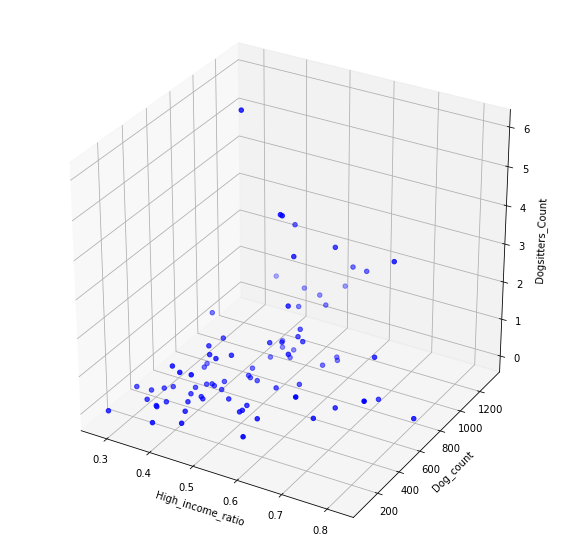

In [33]:
# Plot the Data to see the distributions/relationships
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(df_plot.High_income_ration,df_plot.DOG,df_plot.Dogsitters_Count,c='b',  marker='o')

ax.set_xlabel('High_income_ratio')
ax.set_ylabel('Dog_count')
ax.set_zlabel('Dogsitters_Count')

plt.show()

The 3D scatter plot is quite hard to read. There is an outlier visible. It has a relatively high dogsitters count. It is not clear though whether the dog count is high as well. And it is difficult to tell what the high income ratio is. There are some more neighbourhoods with 2 or 3 dog sitting facilities, but again for those neighbourhoods I can't say what the related income or dog count is. Let's take a look at the 2D scatterplot of the following relations:
- the amount of dogs and the amount of dogsitters
- the number households with an annual income of more than \$70,000 and the amount of dogsitters

#### **Create 2D scatterplots to discover predictors for the amount of dogsitters**

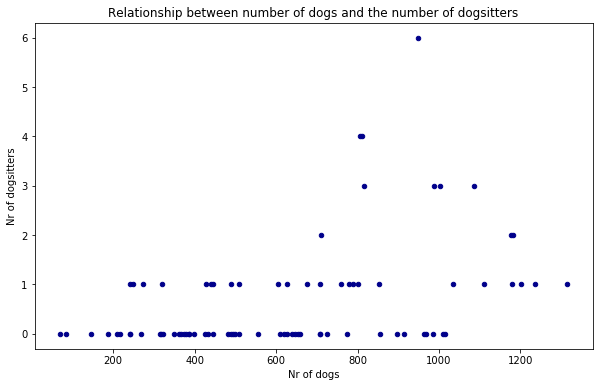

In [34]:
#the amount of dogs and the amount of dogsitters
df_sc_1 = df_toronto_base[['DOG','Dogsitters_Count']]
df_sc_1.plot(kind='scatter',x='DOG',y='Dogsitters_Count',figsize=(10,6), color='darkblue')
plt.title('Relationship between number of dogs and the number of dogsitters')
plt.xlabel('Nr of dogs')
plt.ylabel('Nr of dogsitters')
plt.show()

In a few neighbourhoods, the venues that offer dog minding services increases when the number of dogs is over 700. But it must be said there are neighbourhoods with the same amount of registered dogs that don't have a dog minding venue at all. What is significant is that in neighbourhoods where the amount of registered dogs is a little over 1000 there is at least one dog minding venue. There is an outlier for a neighbourhood with 950 dogs and 6 dog minding facilities. I presume this is a neighbourhood in a central area. We may find out later when plotting a map with the marked clusters on it.

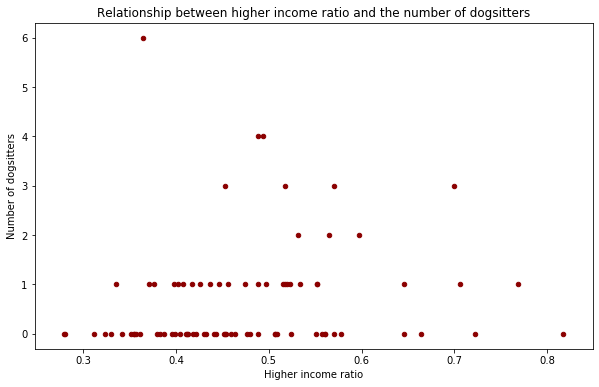

In [35]:
#the amount of dogs and the number of dogsitters
df_sc_2 = df_toronto_base[['70000_plus_ratio','Dogsitters_Count']]
df_sc_2.plot(kind='scatter',x='70000_plus_ratio',y='Dogsitters_Count',figsize=(10,6), color='darkred')
plt.title('Relationship between higher income ratio and the number of dogsitters')
plt.xlabel('Higher income ratio')
plt.ylabel('Number of dogsitters')
plt.show()

What is remarkable is that the outlier we observed in the previous scatter plot is visible again. Apparently it is not so important for these venues that they are in a neighbourhood with a lot customers that can afford to take their dog to a dog sitting service. Maybe when this is indeed a neighbourhood at a crossroads, having neighbourhoods around you with a lot of dogs and enough well earning owners supplies enough clientele. But as I said, we will see later. When the majority of incomes is over 70,000 in a neigbourhood, there is a chance of more than 1 dog minding venue. But half of the venues can be found in neighbourhoods where incomes are for the most part under 70,000. I have no explanation for this.

### **Segmentation and Clustering**

**Prepare dataset for segmentation and clustering**

Create a dataset where categorical columns are removed. They are in the way when calculating Euclidian distances. Next normalize the dataset

In [36]:
from sklearn.preprocessing import StandardScaler
#remove FSA column
df_toronto_num_cols_only = df_toronto_base[['70000_plus_ratio','DOG','Dogsitters_Count']]
#normalize the dataset using StandardScaler
X= df_toronto_num_cols_only[['70000_plus_ratio','DOG']]
y= df_toronto_num_cols_only[['Dogsitters_Count']].values
X= StandardScaler().fit(X).transform(X)
X[0:5]


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


array([[ 0.72338515, -0.00401856],
       [ 2.30091106,  0.47884542],
       [-0.18397975,  1.09221317],
       [-0.79877375, -0.79356642],
       [-1.21735959, -0.75115269]])

**K Nearest Neighbour (KNN) - Find the best K**

Determine the optimal number of clusters.

In [37]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print('Train set:', X_train.shape,y_train.shape)
print('Test set:', X_test.shape,y_test.shape)

Train set: (65, 2) (65, 1)
Test set: (17, 2) (17, 1)


In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks=10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMx = [];
for n in range(1,Ks):
    
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    y_hat=neigh.predict(X_test)
    mean_acc[n-1]=metrics.accuracy_score(y_test,y_hat)
    std_acc[n-1]=np.std(y_hat==y_test)/np.sqrt(y_hat.shape[0])

                        
print('mean_cc:',mean_acc) 

mean_cc: [0.64705882 0.70588235 0.52941176 0.76470588 0.70588235 0.64705882
 0.64705882 0.64705882 0.58823529]


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversion

In [39]:
print('The best accurarcy is with ',mean_acc.max(), ' where k = ', mean_acc.argmax()+1)

The best accurarcy is with  0.7647058823529411  where k =  4


**Visualize the accuracy of the model with different numbers of neighbours**

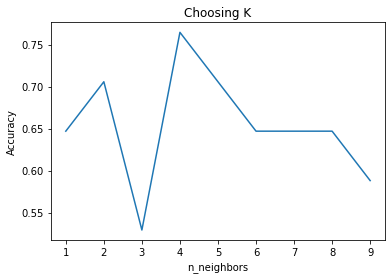

In [40]:
#Generate plot
neighbors = np.arange(1,10)
plt.plot(neighbors, mean_acc, label = 'Accuracy') 

plt.title('Choosing K') 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 

**Cluster the neighbourhoods**

Run k-means and cluster the data into 4 clusters.

In [41]:
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [42]:
# set number of clusters
kclusters = 4

#select only the numerical columns from the dataframe as they are the only relevant columns when calculating distances with k-means
df_toronto_clust = df_toronto_base[['70000_plus_ratio','DOG','Dogsitters_Count']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_toronto_clust)

In [43]:
# add clustering labels to the toronto_base dataframe
df_toronto_labeled = df_toronto_base
df_toronto_labeled.insert(0, 'Cluster Labels', kmeans.labels_)

# it would be nice to have the neighbourhoodsnames, so merge with the df dataframe
df_neigh_names = df[['PostalCode','Borough','Neighbourhood']]
df_toronto_labeled_named =  pd.merge(df_toronto_labeled,df_neigh_names, left_on='FSA', right_on='PostalCode')                   
df_toronto_labeled_named.head(10)

,Cluster Labels,FSA,70000_plus_ratio,DOG,Latitude,Longitude,Dogsitters_Count,PostalCode,Borough,Neighbourhood
0,1,M1B,0.552097,627,43.806686,-79.194353,1.0,M1B,Scarborough,"Rouge, Malvern"
1,1,M1C,0.722772,775,43.784535,-79.160497,0.0,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,3,M1E,0.453927,963,43.763573,-79.188711,0.0,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,2,M1G,0.387412,385,43.770992,-79.216917,0.0,M1G,Scarborough,Woburn
4,2,M1J,0.342124,398,43.744734,-79.239476,0.0,M1J,Scarborough,Scarborough Village
5,1,M1K,0.354043,654,43.727929,-79.262029,0.0,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
6,2,M1L,0.397935,510,43.711112,-79.284577,1.0,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
7,1,M1M,0.523729,627,43.716316,-79.239476,0.0,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
8,1,M1N,0.523370,852,43.692657,-79.264848,1.0,M1N,Scarborough,"Birch Cliff, Cliffside West"
9,2,M1P,0.411975,500,43.757410,-79.273304,0.0,M1P,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ..."


**Name the clusters**

**Cluster label 0 - low dogcount - on average 40% of household incomes above 70,000- practically no dogsitting businesses**

In [44]:
df_toronto_labeled_named.loc[df_toronto_labeled_named['Cluster Labels'] == 0, df_toronto_labeled_named.columns[[1] + list(range(2,4)) + [6] + [9]]]

,FSA,70000_plus_ratio,DOG,Dogsitters_Count,Neighbourhood
17,M2L,0.645914,319,1.0,"Silver Hills, York Mills"
23,M3C,0.311381,322,0.0,"Flemingdon Park, Don Mills South"
25,M3J,0.361179,268,0.0,"Northwood Park, York University"
26,M3L,0.351310,217,0.0,Downsview West
27,M3M,0.398321,318,0.0,Downsview Central
28,M3N,0.278689,314,0.0,Downsview Northwest
29,M4A,0.354686,210,0.0,Victoria Village
34,M4H,0.279804,69,0.0,Thorncliffe Park
47,M5G,0.379104,83,0.0,Central Bay Street
48,M5J,0.560368,186,0.0,"Harbourfront East, Toronto Islands, Union Station"


**Cluster label 1 - medium dog count - on average 50% of household income above 70,000 - 3 neighbourhoods with 3 or 4 dog sitters**

In [45]:
df_toronto_labeled_named.loc[df_toronto_labeled_named['Cluster Labels'] == 1, df_toronto_labeled_named.columns[[1] + list(range(2,4)) + [6] + [9]]]

,FSA,70000_plus_ratio,DOG,Dogsitters_Count,Neighbourhood
0,M1B,0.552097,627,1.0,"Rouge, Malvern"
1,M1C,0.722772,775,0.0,"Highland Creek, Rouge Hill, Port Union"
5,M1K,0.354043,654,0.0,"East Birchmount Park, Ionview, Kennedy Park"
7,M1M,0.523729,627,0.0,"Cliffcrest, Cliffside, Scarborough Village West"
8,M1N,0.523370,852,1.0,"Birch Cliff, Cliffside West"
15,M2J,0.451155,659,0.0,"Fairview, Henry Farm, Oriole"
21,M3A,0.458709,646,0.0,Parkwoods
24,M3H,0.497034,675,1.0,"Bathurst Manor, Downsview North, Wilson Heights"
33,M4G,0.706065,802,1.0,Leaside
38,M4M,0.534161,788,1.0,Studio District


**Cluster label 2 - low to medium dog count - on average 45% of households earn more than 70,000 - practically no dogsitting businesses**

In [46]:
df_toronto_labeled_named.loc[df_toronto_labeled_named['Cluster Labels'] == 2, df_toronto_labeled_named.columns[[1] + list(range(2,4)) + [6] + [9]]]

,FSA,70000_plus_ratio,DOG,Dogsitters_Count,Neighbourhood
3,M1G,0.387412,385,0.0,Woburn
4,M1J,0.342124,398,0.0,Scarborough Village
6,M1L,0.397935,510,1.0,"Clairlea, Golden Mile, Oakridge"
9,M1P,0.411975,500,0.0,"Dorset Park, Scarborough Town Centre, Wexford ..."
10,M1S,0.436039,428,1.0,Agincourt
11,M1T,0.411034,387,0.0,"Clarks Corners, Sullivan, Tam O'Shanter"
12,M1V,0.463256,433,0.0,"Agincourt North, L'Amoreaux East, Milliken, St..."
13,M1W,0.417221,444,1.0,L'Amoreaux West
14,M2H,0.507031,361,0.0,Hillcrest Village
16,M2K,0.508784,379,0.0,Bayview Village


**Cluster label 3 - high dog count - on average 50% of households earn over 70,000 - two thirds of neighbourhoods have dogsitting businesses**

In [47]:
df_toronto_labeled_named.loc[df_toronto_labeled_named['Cluster Labels'] == 3, df_toronto_labeled_named.columns[[1] + list(range(2,4)) + [6] + [9]]]

,FSA,70000_plus_ratio,DOG,Dogsitters_Count,Neighbourhood
2,M1E,0.453927,963,0.0,"Guildwood, Morningside, West Hill"
19,M2N,0.474468,1034,1.0,Willowdale South
31,M4C,0.446370,1201,1.0,Woodbine Heights
32,M4E,0.565171,1181,2.0,The Beaches
35,M4J,0.519594,1110,1.0,East Toronto
36,M4K,0.479452,967,0.0,"The Danforth West, Riverdale"
37,M4L,0.515428,1315,1.0,"The Beaches West, India Bazaar"
46,M5A,0.364407,949,6.0,"Harbourfront, Regent Park"
49,M5M,0.700178,1003,3.0,"Bedford Park, Lawrence Manor East"
54,M5V,0.570402,987,3.0,"CN Tower, Bathurst Quay, Island airport, Harbo..."


### **Visualize the clusters on a Folium leaflet map**

**Create a map and show the cluster markers**

Let's plot a map with the neighbourhoods and the marked clusters

In [48]:
# create map around central location in Toronto
toronto_central_lat=43.741667
toronto_central_long=-79.373333

map_clusters = folium.Map(location=[toronto_central_lat, toronto_central_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
bright = ['#15ff00', '#0e3cdf', '#f9d503', '#ff0000']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_toronto_labeled_named['Latitude'].tolist(), df_toronto_labeled_named['Longitude'].tolist(), df_toronto_labeled_named['Neighbourhood'].tolist(), df_toronto_labeled_named['Cluster Labels'].tolist()):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=bright[int(cluster)-1],
        fill=True,
        fill_color=bright[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Explanation colours in map:
- Red: Cluster 0 - no chance of starting a succesful business here - few dogs - just 40% of households earning over 70,000
- Green: Cluster 1 - starting a business may be succesful - medium dog count - 50% of households have an income of 70,000 or more - a few neighbourhoods with 3 to 4 dog sitting businesses
- Blue: Cluster 2 - low to medium dog count - 45% of households have incomes of 70,000 or more - very few dogsitting businesses
- Yellow: Cluster 2 - high dog count - 50% of households have incomes of 70,000 or more - 1 in 3 neighbourhoods lack a dog sitting business